In [1]:
import requests
import tarfile
import os
import numpy as np
from PIL import Image
import cv2
import shutil
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
cur_device = "cpu"
from tqdm import tqdm,trange
import torch.optim as optim
import torch.nn.functional as F
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [2]:
def color_channel_first(x):
    rchannel = x[:,:,0]
    gchannel = x[:,:,1]
    bchannel = x[:,:,2]
    return np.array([rchannel,gchannel,bchannel])

In [3]:
# download cmu faces image dataset, and convert it to torch tensor
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/faces-mld/faces.tar.gz'
response = requests.get(URL)
open('faces.tar.gz', 'wb').write(response.content)
with tarfile.open('faces.tar.gz', "r:gz") as cur_tar:
    cur_tar.extractall(os.getcwd())
os.remove('faces.tar.gz')

ext = '.pgm'
headval = {"straight":0,"left":1,"right":2,"up":3}
faceval = {"neutral":0,"happy":1,"sad":2,"angry":3}
eyeval = {"open":0,"sunglasses":1}
f_to_idx = lambda x: [headval[x[0]],faceval[x[1]],eyeval[x[2]]]

X = []
Y = []

for subdir,dirs,files in os.walk(os.path.join(os.getcwd(),'faces')):
    for file_val in files:
        curfile = os.path.join(subdir,file_val)
        if curfile.endswith(ext):
            if not (curfile.endswith('_2'+ext) or curfile.endswith('_4'+ext)):
                X.append(cv2.imread(curfile))
                attrs = file_val[:-4].split('_')[1:]
                Y.append(np.array(f_to_idx(attrs)))
                
shutil.rmtree(os.path.join(os.getcwd(),'faces'))

# process the data to bring color channel first
X = np.array(X)
Y = np.array(Y)
Xtemp = []
for i in range(X.shape[0]):
    Xtemp.append(color_channel_first(X[i,:,:,:]))
X = np.array(Xtemp)

device = torch.device(cur_device)
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

# split into train and validation sets
val_elements = 100
val_idx = np.random.randint(0,X.shape[0],size=(val_elements))
train_idx = np.setdiff1d(np.array(range(X.shape[0])),val_idx)
X_train = X[train_idx,:,:,:]
Y_train = Y[train_idx,:]
X_val = X[val_idx,:,:,:]
Y_val = Y[val_idx,:]

In [4]:
class MoodNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,8)
        self.pool = nn.MaxPool2d((5,5))
        self.conv2 = nn.Conv2d(6,10,8)
        self.fc1 = nn.Linear(90,45)
        self.fc2 = nn.Linear(45,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,start_dim=1,end_dim=3)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [5]:
# training loop
model = MoodNet().to(device)
X_train = X_train.float().to(device)
Y_train = Y_train.long().to(device)
X_val = X_val.float().to(device)
Y_val = Y_val.long().to(device)
optimizer = optim.SGD(model.parameters(), lr=5e-4)
n_epochs = 1000
loss_fn = nn.CrossEntropyLoss()
losses = []
val_losses = []
BS = 8 # batch size

for i in (t:=trange(n_epochs)):
    samp = np.random.randint(0,X_train.shape[0],(BS))
    X = X_train[samp,:,:,:]
    Y = Y_train[samp,:]
    out = model(X)
    l1 = loss_fn(out[:,:4],Y[:,0])
    l2 = loss_fn(out[:,4:8],Y[:,1])
    l3 = loss_fn(out[:,8:],Y[:,2])
    loss = l1+l2+l3
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()
    losses.append(loss.item())
    # calculate val loss
    val_out = model(X_val)
    l1v = loss_fn(val_out[:,:4],Y_val[:,0])
    l2v = loss_fn(val_out[:,4:8],Y_val[:,1])
    l3v = loss_fn(val_out[:,8:],Y_val[:,2])
    lv = l1v+l2v+l3v
    val_losses.append(lv.mean().item())
    t.set_description("train loss %.3f, val loss %.3f" % (loss.item(),lv.item()))

train loss 1.097, val loss 2.358: 100%|██████████| 1000/1000 [01:00<00:00, 16.59it/s]


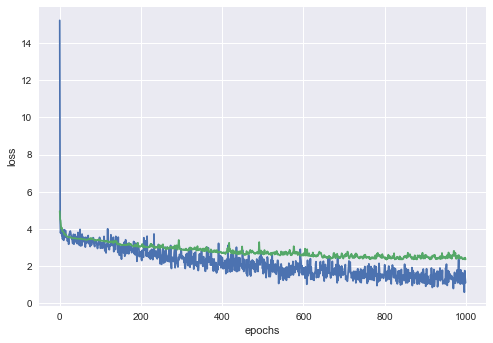

In [6]:
import matplotlib as mpl
mpl.style.use('seaborn')
plt.plot(losses,label='train loss')
plt.plot(val_losses,label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()